Epoch 1/10


C:\Users\anmol\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - AUC: 0.7996 - accuracy: 0.7252 - loss: 0.5303
Epoch 1: val_loss improved from inf to 0.20724, saving model to best_model.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - AUC: 0.8008 - accuracy: 0.7264 - loss: 0.5287 - val_AUC: 0.9786 - val_accuracy: 0.9219 - val_loss: 0.2072
Epoch 2/10
 1/84 ━━━━━━━━━━━━━━━━━━━━ 1:09 835ms/step - AUC: 0.9922 - accuracy: 0.9375 - loss: 0.1715

C:\Users\anmol\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 0.20724 to 0.04779, saving model to best_model.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - AUC: 0.9922 - accuracy: 0.9375 - loss: 0.0867 - val_AUC: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0478
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - AUC: 0.9773 - accuracy: 0.9275 - loss: 0.2051
Epoch 3: val_loss did not improve from 0.04779
84/84 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - AUC: 0.9773 - accuracy: 0.9276 - loss: 0.2049 - val_AUC: 0.9906 - val_accuracy: 0.9275 - val_loss: 0.1693
Epoch 4/10
 1/84 ━━━━━━━━━━━━━━━━━━━━ 1:07 815ms/step - AUC: 0.9570 - accuracy: 0.9062 - loss: 0.2302
Epoch 4: val_loss improved from 0.04779 to 0.00591, saving model to best_model.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.9570 - accuracy: 0.9062 - loss: 0.1165 - val_AUC: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0059
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - AUC: 0.9925 - accuracy: 0.9599 - loss: 0.1313
Epoch 5: val_loss did not improve from

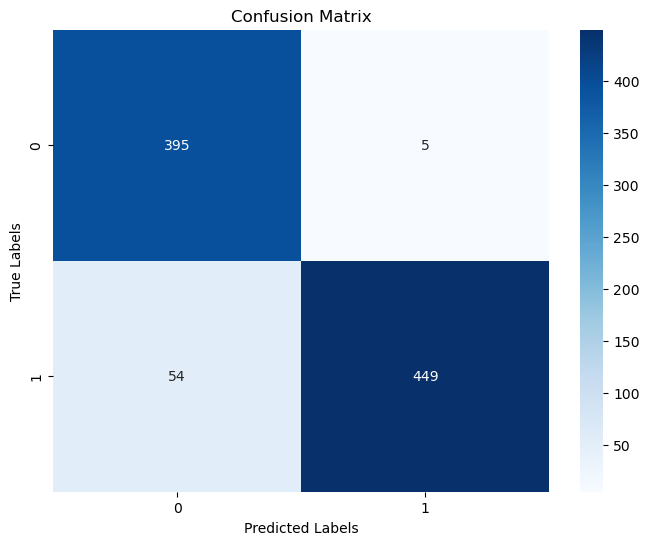

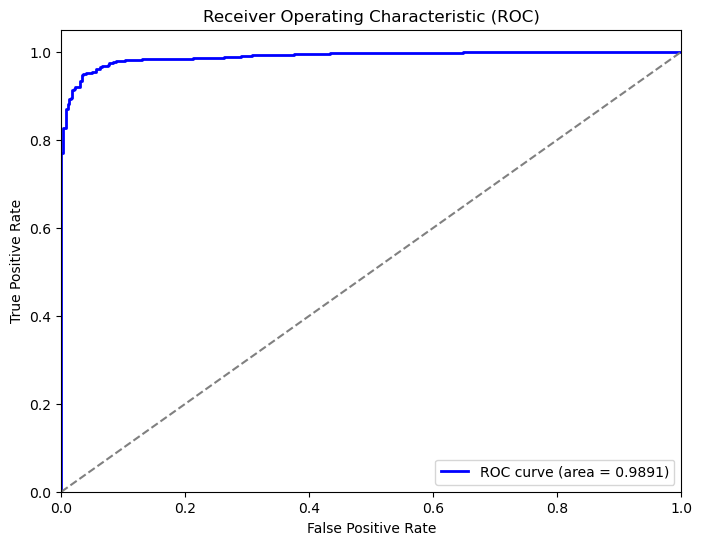

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define paths for brain tumor dataset
tumor_data_dir = 'C:\\Users\\anmol\\Desktop\\New folder\\Brain Tumor Data Set\\Brain Tumor Data Set\\Brain Tumor'
no_tumor_data_dir = 'C:\\Users\\anmol\\Desktop\\New folder\\Brain Tumor Data Set\\Brain Tumor Data Set\\Healthy'

# Input image dimensions
img_width, img_height = 224, 224
batch_size = 32
epochs = 10

# Load images from directory and resize
def load_images_from_directory(directory, label):
    images, labels = [], []
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img_resized = cv2.resize(img, (img_width, img_height))
                images.append(img_resized)
                labels.append(label)
    return images, labels

# Load and preprocess data
tumor_images, tumor_labels = load_images_from_directory(tumor_data_dir, 1)
no_tumor_images, no_tumor_labels = load_images_from_directory(no_tumor_data_dir, 0)

images = np.array(tumor_images + no_tumor_images)
labels = np.array(tumor_labels + no_tumor_labels)

# Split dataset (60% training, 20% validation, 20% testing)
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Data augmentation for training
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_test_datagen.flow(X_val, y_val, batch_size=batch_size)
test_generator = val_test_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

# Use MobileNetV2 as the base model (without the top layers)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model (to avoid training it again)
base_model.trainable = False

# Custom CNN layers on top of MobileNetV2
inputs = Input(shape=(img_height, img_width, 3))

# Pass the input through the base model (MobileNetV2)
x = base_model(inputs, training=False)

# Add your custom CNN layers
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)

# Fully connected layers
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

# Output layer for binary classification
outputs = Dense(1, activation='sigmoid')(x)

# Build the model
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

# Define callbacks: early stopping and saving the best model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the model
start_time = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=val_generator,
    validation_steps=len(X_val) // batch_size,
    epochs=epochs,
    callbacks=callbacks
)

# Evaluate the model on the test set
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1).ravel()

# Compute AUC score
auc_score = roc_auc_score(y_test, y_pred)
print(f'Test AUC: {auc_score}')

# Confusion matrix and classification report
y_pred_labels = (y_pred > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred_labels)
print(f'Confusion Matrix:\n{conf_matrix}')

class_report = classification_report(y_test, y_pred_labels)
print(f'Classification Report:\n{class_report}')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


NameError: name 'model' is not defined